In [1]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import glob
import copy
import neptune
#import splitfolders
import matplotlib.gridspec as gridspec
cudnn.benchmark = True
plt.ion()


In [2]:

#splitfolders.ratio(
#  "C:\data\dataset",
#   output='C:\data\dataset\split',
#   seed=42,
#    ratio=(.8, .1, 0.1),
#    group_prefix=None,
  #  move=False)
    
run = neptune.init_run(
    project="neas1231/Neas1231",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJmY2VjMGIzOS01ZjI1LTQ1MTItODQxYi0zMjIyOWIwYWI0MzIifQ==",
)

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'E:\datasets\dataset'
run["config/data_dir"] = data_dir

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
              for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=10,
                                             shuffle=True, num_workers=8)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) 
              for x in ['train', 'val']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

D:\hroneniyas\anacondas\envs\gputorch\lib\site-packages\neptune\common\warnings.py:62: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  warnings.warn(


https://app.neptune.ai/neas1231/Neas1231/e/NEAS-15


In [3]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    acc = (torch.sum(preds == labels.data)) / len(inputs)
                    run["logs/training/batch/loss"].append(loss)
                    run["logs/training/batch/acc"].append(acc)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated



In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far,)
                ax.axis('on')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [6]:
model_ft = models.efficientnet_b4(pretrained=True)
#num_ftrs = model_ft.fc.in_features
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(1, len(class_names))

model_ft = model_ft.to(device)
run["config/model"] = model_ft

criterion = nn.CrossEntropyLoss()
run["config/criterion"] =criterion

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
run["config/optimizer"] = optimizer_ft
run["parameters"] = model_ft.parameters()

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

D:\hroneniyas\anacondas\envs\gputorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\hroneniyas\anacondas\envs\gputorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
D:\hroneniyas\anacondas\envs\gputorch\lib\site-packages\neptune\common\warnings.py:62: NeptuneUnsupportedType: You're attempting to log a type that is not directly supported by Neptune (<class 'torchvision.models.efficientnet.EfficientNet'>).
        Convert the value to a supported type, such as a string or float, or use stringi

In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=14)

Epoch 0/13
----------
train Loss: 0.9951 Acc: 0.6927
val Loss: 0.4877 Acc: 0.8495

Epoch 1/13
----------
train Loss: 0.6158 Acc: 0.7959
val Loss: 0.3549 Acc: 0.8744

Epoch 2/13
----------
train Loss: 0.5415 Acc: 0.8130
val Loss: 0.3273 Acc: 0.8947

Epoch 3/13
----------
train Loss: 0.5083 Acc: 0.8308
val Loss: 0.3124 Acc: 0.8994

Epoch 4/13
----------
train Loss: 0.4667 Acc: 0.8374
val Loss: 0.4752 Acc: 0.8929

Epoch 5/13
----------
train Loss: 0.4506 Acc: 0.8493
val Loss: 0.2532 Acc: 0.9169

Epoch 6/13
----------
train Loss: 0.4304 Acc: 0.8536
val Loss: 0.3022 Acc: 0.8994

Epoch 7/13
----------
train Loss: 0.3248 Acc: 0.8847
val Loss: 0.2452 Acc: 0.9215

Epoch 8/13
----------
train Loss: 0.2794 Acc: 0.9045
val Loss: 0.2235 Acc: 0.9298

Epoch 9/13
----------
train Loss: 0.2513 Acc: 0.9158
val Loss: 0.2447 Acc: 0.9280

Epoch 10/13
----------
train Loss: 0.2395 Acc: 0.9164
val Loss: 0.2337 Acc: 0.9243

Epoch 11/13
----------
train Loss: 0.2291 Acc: 0.9186
val Loss: 0.2238 Acc: 0.9234

Ep

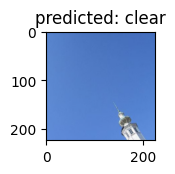

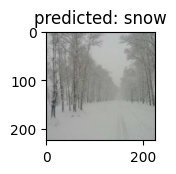

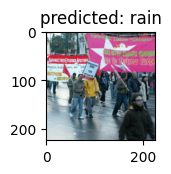

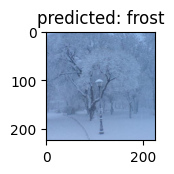

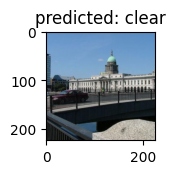

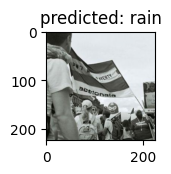

In [8]:
visualize_model(model_ft)

In [11]:
torch.save(model_ft,'0.933518acc-0.2152loss.pth')
torch.save(model_ft.state_dict(), "weights-0.933518acc-0.2152loss.pth")

In [10]:
jupyter notebook list

SyntaxError: invalid syntax (1373106854.py, line 1)

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)
import gc
gc.collect()
import torch
torch.cuda.empty_cache()

In [15]:
model_conv = torchvision.models.efficientnet_b4(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.classifier[1].in_features

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.Adam(model_conv.classifier[1].parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [16]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler,
                       num_epochs=14)

Epoch 0/13
----------


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn